# Submission 03  for San Francisco Crime Classification
Yang Yang Qian<br>
Linda Dong<br>
Arthur Silveira Lima

In this notebook we will work on the problem proposed by Kaggle named: San Francisco Crime Classification<br>
You can find more info here: https://www.kaggle.com/c/sf-crime/overview/description
<br><br>
The objective of this notebook is to classify a crime using the covariantes that is presented by the data set.
In order to assess the performance we will use logloss.
<br>
The team has developed a pipeline to test different possibilities and is using GridSearch to find the optimal parameters. Multiple ML algorithms have been used, among those we have: KNN, Multivariable, Logistics, Random Forest, X-boosted Three, among others.

In [1]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

%reload_ext autoreload
%autoreload 2
# from src.features.build_features import DataFrameSelector, SFCCTransformer, print_summary, prep_submissions

import inspect

import seaborn as sns
sns.set(style="ticks", color_codes=True)
import matplotlib.pyplot as plt

In [2]:
%run ../src/features/build_features.py

# Load Data

In [15]:
train_pd = pd.read_csv("../data/raw/train.csv")
test_pd = pd.read_csv("../data/raw/test.csv")
sample_submissions = pd.read_csv("../data/raw/sampleSubmission.csv")

In [16]:
# extract some more features using our custom transformer
sfcc = SFCCTransformer()
pipe = Pipeline([
    ("transformer", sfcc)
])
train_pd = pipe.transform(train_pd)
test_pd = pipe.transform(test_pd)

# EDA

We have about 800k records in both train and test data sets. The train data set has the Category, Descript, and Resolution columns, which are missing from the test data set.

We will need to use the test data set to generate the submission to Kaggle.

TODO add more plots and EDA from scratch EDA

In [5]:
print(train_pd.shape)
print(test_pd.shape)

(878049, 142)
(884262, 141)


In [6]:
train_pd.head(3)

,Category,Descript,Resolution,X,Y,pdd_BAYVIEW,pdd_CENTRAL,pdd_INGLESIDE,pdd_MISSION,pdd_NORTHERN,...,day_of_month_sin,day_of_month_cos,day_of_year_sin,day_of_year_cos,week_of_year_sin,week_of_year_cos,month_of_year_sin,month_of_year_cos,quarter_of_year_sin,quarter_of_year_cos
0,WARRANTS,WARRANT ARREST,"ARREST, BOOKED",0.59,0.595,0,0,0,0,1,...,0.826,0.118,0.884,0.18,0.888,0.185,0.933,0.25,1.0,0.5
1,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,"ARREST, BOOKED",0.59,0.595,0,0,0,0,1,...,0.826,0.118,0.884,0.18,0.888,0.185,0.933,0.25,1.0,0.5
2,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,"ARREST, BOOKED",0.60,0.825,0,0,0,0,1,...,0.826,0.118,0.884,0.18,0.888,0.185,0.933,0.25,1.0,0.5


In [7]:
test_pd.head(3)

,Id,X,Y,pdd_BAYVIEW,pdd_CENTRAL,pdd_INGLESIDE,pdd_MISSION,pdd_NORTHERN,pdd_PARK,pdd_RICHMOND,...,day_of_month_sin,day_of_month_cos,day_of_year_sin,day_of_year_cos,week_of_year_sin,week_of_year_cos,month_of_year_sin,month_of_year_cos,quarter_of_year_sin,quarter_of_year_cos
0,0,0.766,0.241,1,0,0,0,0,0,0,...,0.985,0.373,0.9,0.2,0.925,0.232,0.933,0.25,1.0,0.5
1,1,0.820,0.218,1,0,0,0,0,0,0,...,0.985,0.373,0.9,0.2,0.925,0.232,0.933,0.25,1.0,0.5
2,2,0.589,0.748,0,0,0,0,1,0,0,...,0.985,0.373,0.9,0.2,0.925,0.232,0.933,0.25,1.0,0.5


**Checking for NAs in the base**
* in both test and train data set 
* remove the row if there's a NA

In [8]:
print('The test_pd original shape is: '+ str(test_pd.shape))
test_pd = test_pd.dropna()
print('The test_pd NEW shape is: '+ str(test_pd.shape))

print('The train_pd original shape is: '+ str(train_pd.shape))
train_pd = train_pd.dropna()
print('The train_pd NEW shape is: '+ str(train_pd.shape))

The test_pd original shape is: (884262, 141)
The test_pd NEW shape is: (884262, 141)
The train_pd original shape is: (878049, 142)
The train_pd NEW shape is: (878049, 142)


**Category**
* categorical variable with 39 levels
* is what we are trying to predict
* largest Category of crimes is theft, at around 20% of all crime

In [9]:
print('The total number of categories is: ' + str(len(train_pd.Category.unique())))

The total number of categories is: 39


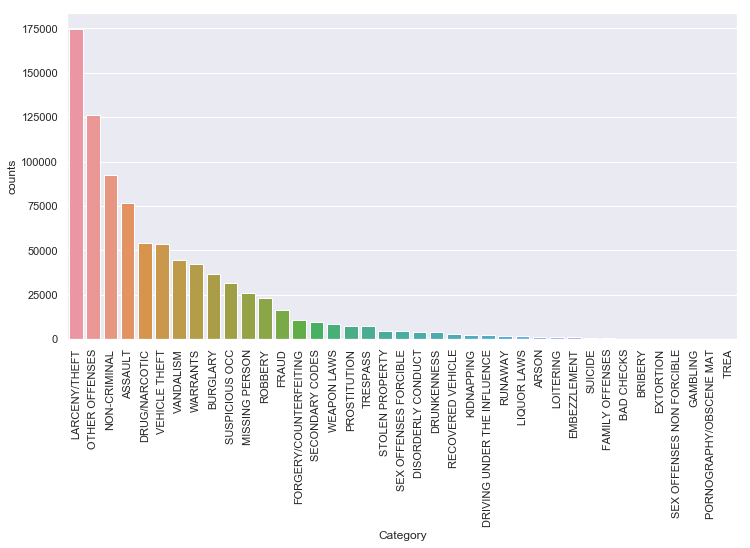

In [10]:
dat = train_pd.groupby(["Category"]).size().reset_index(name='counts').sort_values(by = "counts", ascending = False)

sns.set(rc = {"figure.figsize" : (12, 6)})
ax = sns.barplot(x = "Category", y = "counts", data=dat). \
    set_xticklabels(dat['Category'],rotation = 90)

**PdDistrict**
* categorical variable with 10 levels
* should be roughly correlated with X and Y ?
* southern district appears to have the highest number of reported crimes. Maybe larger district? more cops? or just more crime?

In [19]:
print('The total number of PdDistricts is: ' + str(len(train_pd.PdDistrict.unique())))

The total number of PdDistricts is: 10


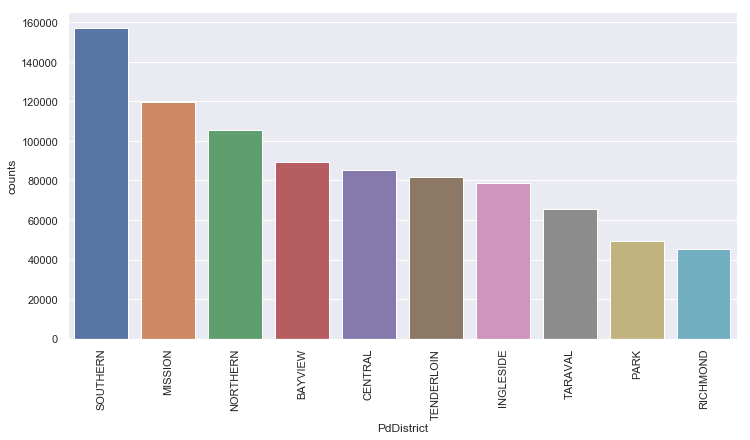

In [20]:
dat = train_pd.groupby(["PdDistrict"]).size().reset_index(name='counts').sort_values(by = "counts", ascending = False)

sns.set(rc = {"figure.figsize" : (12, 6)})
ax = sns.barplot(x="PdDistrict", y="counts", data=dat). \
    set_xticklabels(dat['PdDistrict'], rotation = 90)


**Address**
* might be able to extract street from this
* probably correlated with X and Y

In [ ]:
print('The total number of unique Addresses is: ' + str(len(train_pd.Address.unique())))

In [22]:
print('The top Adresses are: '+str(train_pd.Address.value_counts()[0:5]))

The top Adresses are: 800 Block of BRYANT ST      26533
800 Block of MARKET ST       6581
2000 Block of MISSION ST     5097
1000 Block of POTRERO AV     4063
900 Block of MARKET ST       3251
Name: Address, dtype: int64


**Y and X**

* lattitude and Longitude
* appears to have some outliers, maybe some mis-coded locations?
* we have outliers in both train and test
* rounding the values to the 10th decimal

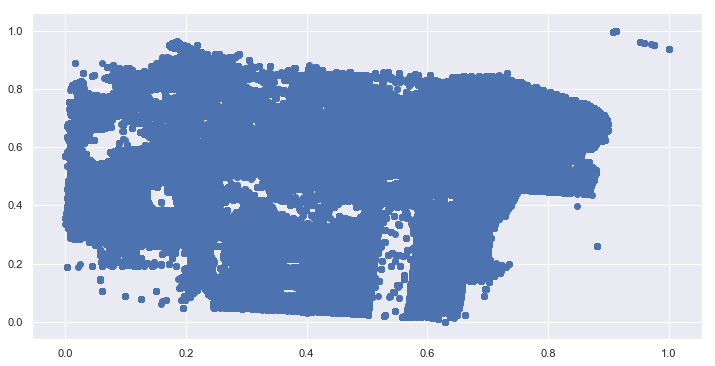

In [12]:
# Plot
plt.scatter(train_pd['Y'], train_pd['X'])
plt.show()

The latitude of San Francisco, CA, USA is 37.773972, and the longitude is -122.431297.
<br>Anything below lng -122.30 and  lat above 38 will be excluded from both train e test data set

In [13]:
print('Before the cleaning the shape was: '+str(train_pd.shape))
keep_train = train_pd[(train_pd['Y'] < 38) & (train_pd['X'] < -121.30)].index
train_pd = train_pd.iloc[keep_train].reset_index(drop=True)
print('After the cleaning the shape is: '+str(train_pd.shape))

print('Before the cleaning the shape was: '+str(test_pd.shape))
keep_test = test_pd[(train_pd['Y'] < 38) & (test_pd['X'] < -121.30)].index
test_pd = test_pd.iloc[keep_test].reset_index(drop=True)
print('After the cleaning the shape is: '+str(test_pd.shape))

Before the cleaning the shape was: (878049, 142)
After the cleaning the shape is: (0, 142)
Before the cleaning the shape was: (884262, 141)
After the cleaning the shape is: (0, 141)


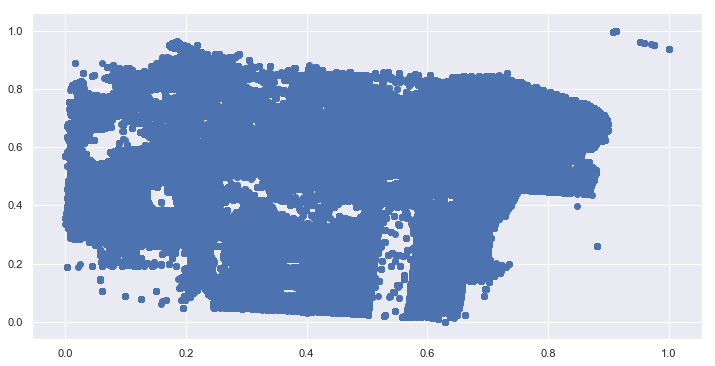

In [17]:
# Plot
plt.scatter(train_pd['Y'], train_pd['X'])
plt.show()

In [56]:
#rounding
train_pd['X']=train_pd['X'].round(10)
train_pd['Y']=train_pd['Y'].round(10)

test_pd['X']=test_pd['X'].round(10)
test_pd['Y']=test_pd['Y'].round(10)

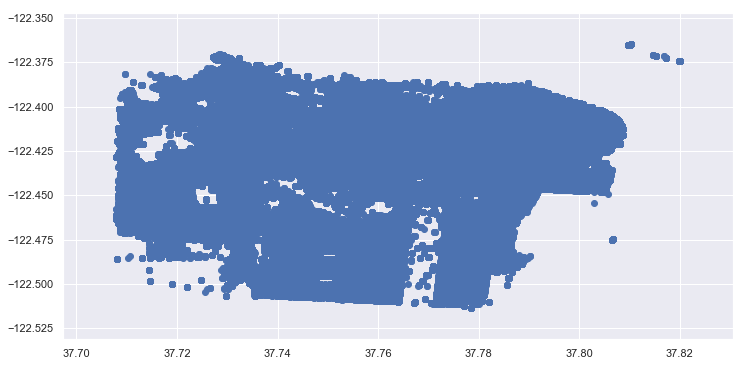

In [57]:
# Plot
plt.scatter(train_pd['Y'], train_pd['X'])
plt.show()

**DayOfWeek**

* categorical variable with 7 levels
* looks like number of reported crimes is highest on Friday for some reason
* highest vs lowest is about 12% decrease

In [ ]:
dat = train_pd.groupby(["DayOfWeek"]).size().reset_index(name='counts').sort_values(by = "counts", ascending = False)

sns.set(rc = {"figure.figsize" : (12, 6)})
ax = sns.barplot(x = "DayOfWeek", y = "counts", data=dat).\
    set_xticklabels(dat['DayOfWeek'], rotation = 90)


**Resolution**
* not available in Test data
* not very useful for prediction classification task

**Dates**
* transforming the dates
* droping the minutes
* creating one column with the hour of the day
* Transforming in numbers

In [ ]:
#working on dates
#transforming the dates
train_pd['Dates'] = pd.to_datetime(train_pd['Dates'])
test_pd['Dates'] = pd.to_datetime(test_pd['Dates'])

#droping the minutes
train_pd['Dates']=train_pd['Dates'].dt.round('H')
test_pd['Dates']=test_pd['Dates'].dt.round('H')

#creating one column with the hour of the day
train_pd['hour']=train_pd['Dates'].dt.hour
test_pd['hour']=test_pd['Dates'].dt.hour


#transforming the dates to numbers
train_pd['Dates']=pd.to_numeric(train_pd['Dates'])
train_pd['Dates']=train_pd['Dates']/10000
train_pd['Dates']=train_pd['Dates'].round(0)
test_pd['Dates']=pd.to_numeric(test_pd['Dates'])
test_pd['Dates']=test_pd['Dates']/10000
test_pd['Dates']=test_pd['Dates'].round(0)

In [ ]:
print('The total number of unique Dates is: ' + str(len(train_pd.Dates.unique())))

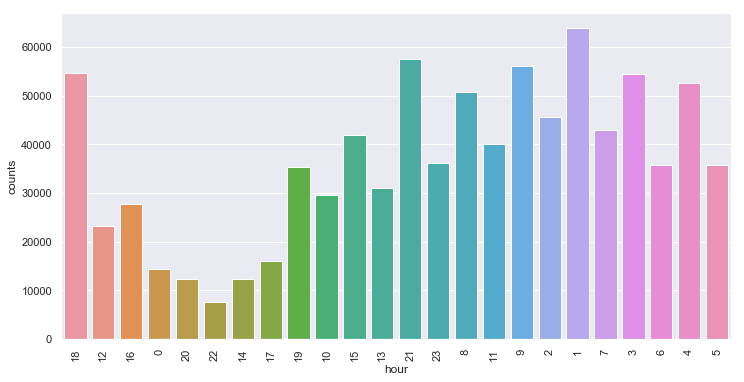

In [32]:
dat = train_pd.groupby(["hour"]).size().reset_index(name='counts').sort_values(by = "counts", ascending = False)

sns.set(rc = {"figure.figsize" : (12, 6)})
ax = sns.barplot(x = "hour", y = "counts", data=dat).\
    set_xticklabels(dat['hour'], rotation = 90)

In [39]:
#creating a variable for weekdays and weekend
train_pd['weekend'] = train_pd['DayOfWeek']
train_pd['weekend'] = train_pd['weekend'].replace('Sunday', 1)
train_pd['weekend'] = train_pd['weekend'].replace('Monday', 0)
train_pd['weekend'] = train_pd['weekend'].replace('Tuesday', 0)
train_pd['weekend'] = train_pd['weekend'].replace('Wednesday', 0)
train_pd['weekend'] = train_pd['weekend'].replace('Thursday', 0)
train_pd['weekend'] = train_pd['weekend'].replace('Friday', 0)
train_pd['weekend'] = train_pd['weekend'].replace('Saturday', 1)

test_pd['weekend'] = test_pd['DayOfWeek']
test_pd['weekend'] = test_pd['weekend'].replace('Sunday', 1)
test_pd['weekend'] = test_pd['weekend'].replace('Monday', 0)
test_pd['weekend'] = test_pd['weekend'].replace('Tuesday', 0)
test_pd['weekend'] = test_pd['weekend'].replace('Wednesday', 0)
test_pd['weekend'] = test_pd['weekend'].replace('Thursday', 0)
test_pd['weekend'] = test_pd['weekend'].replace('Friday', 0)
test_pd['weekend'] = test_pd['weekend'].replace('Saturday', 1)

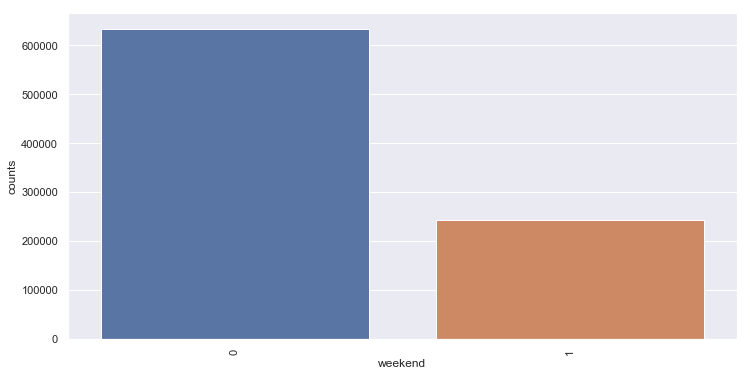

In [40]:
dat = train_pd.groupby(["weekend"]).size().reset_index(name='counts').sort_values(by = "counts", ascending = False)

sns.set(rc = {"figure.figsize" : (12, 6)})
ax = sns.barplot(x = "weekend", y = "counts", data=dat).\
    set_xticklabels(dat['weekend'], rotation = 90)


**Checking PCA to understand the explicability of the variables**
* this can help us understand which ones are worthy to keep

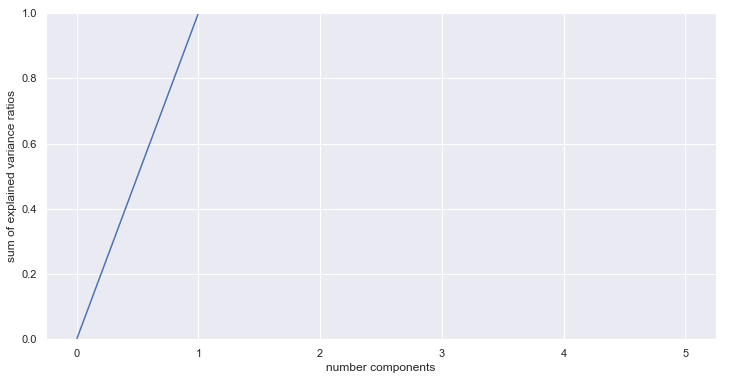

In [47]:
#setting the number of componentes
n_comp = 5

# perform PCA
pca_mod = PCA(n_components = n_comp)
pca_mod.fit(train_pd[['Dates','X','Y','hour','weekend']])

evr = pca_mod.explained_variance_ratio_
s_evr = np.cumsum(np.concatenate(([0], evr)))

#ploting the first components to the total variance that can be explained by those
plt.plot(range(n_comp+1),s_evr)
plt.xlabel('number components')
plt.ylabel('sum of explained variance ratios')
plt.ylim([0,1])
plt.show()


**Shuffle the data**
* Shuffle the data to avoid issues with it

In [20]:
train_pd = train_pd.sample(frac=1).reset_index(drop=True)

# Classification

In [ ]:
# TODO add feature selection

In [24]:
train_data = train_pd.copy()
print(train_data.shape)

# gets the train labels
train_labels = train_data["Category"]

print(train_labels.shape)

(878049, 142)
(878049,)


In [ ]:
# pipeline to prep our data and fit classifiers
selector = DataFrameSelector(["X", "Y","day_of_month_sin","day_of_month_cos"\
                             ,"day_of_year_sin","day_of_year_cos","week_of_year_sin","week_of_year_cos"])
knn = KNeighborsClassifier()

pipe = Pipeline([
    ("selector", selector)
    ,("knn", knn)
])

# TODO add more classifier types and attributes, use list of dicts for alt paths
# TODO figure out how to add ensembles to this, maybe with soft voting?
# TODO SVM, knn, random forest, etc
param_grid = {
    "selector__attribute_names": [
        ["X", "Y"]
            ,["X", "Y","day_of_month_sin","day_of_month_cos"\
                             ,"day_of_year_sin","day_of_year_cos","week_of_year_sin","week_of_year_cos"]
    ]
    ,"knn__n_neighbors": [3, 5, 10, 15, 20, 25, 30, 40, 50, 100]
}

# TODO figure out how to do stratified kfold by category
# TODO figure out how to add bagging to this
search = GridSearchCV(pipe, param_grid,scoring='neg_log_loss' ,iid = True, cv = 3, return_train_score = False)

_ = search.fit(train_data, train_labels)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

In [ ]:
# pipeline to prep our data and fit classifiers
selector = DataFrameSelector(["X", "Y","day_of_month_sin","day_of_month_cos"\
                             ,"day_of_year_sin","day_of_year_cos","week_of_year_sin","week_of_year_cos"])
knn = KNeighborsClassifier()
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100]

for estimator in n_estimators:
    random_forest = RandomForestClassifier(n_estimators=estimator)
    xboosted = GradientBoostingClassifier()


    pipe = Pipeline([
        ("selector", selector)
        ,("random_forest", random_forest)
    #     ,("gradient_boosted", xboosted)
    #     ,("knn", knn)
    #     ,("", MultinomialNB)
    ])

    # TODO add more classifier types and attributes, use list of dicts for alt paths
    # TODO figure out how to add ensembles to this, maybe with soft voting?
    # TODO SVM, knn, random forest, etc
    param_grid = {
        "selector__attribute_names": [
            ["X", "Y"]
            ,["X", "Y","day_of_month_sin","day_of_month_cos"\
                             ,"day_of_year_sin","day_of_year_cos","week_of_year_sin","week_of_year_cos"]
    #         , ["X", "Y", "is_latenight"]
    #         ,["hour_of_day_sin", "hour_of_day_cos"]
    #         ,["X", "Y", "hour_of_day_sin", "hour_of_day_cos"]
        ]
    #     ,"knn__n_neighbors": [3, 16, 26]
    }

    # TODO figure out how to do stratified kfold by category
    # TODO figure out how to add bagging to this
    search = GridSearchCV(pipe, param_grid,scoring='neg_log_loss' ,iid = True, cv = 3, return_train_score = False)

    _ = search.fit(train_data, train_labels)
    print("Best parameter (CV score=%0.3f):" % search.best_score_)
    print(search.best_params_)

Best parameter (CV score=-8.393):
{'selector__attribute_names': ['X', 'Y']}
Best parameter (CV score=-7.158):
{'selector__attribute_names': ['X', 'Y']}
Best parameter (CV score=-6.641):
{'selector__attribute_names': ['X', 'Y']}
Best parameter (CV score=-6.467):
{'selector__attribute_names': ['X', 'Y']}
Best parameter (CV score=-6.339):
{'selector__attribute_names': ['X', 'Y']}
Best parameter (CV score=-6.210):
{'selector__attribute_names': ['X', 'Y']}
Best parameter (CV score=-6.075):
{'selector__attribute_names': ['X', 'Y']}
Best parameter (CV score=-5.988):
{'selector__attribute_names': ['X', 'Y']}


In [ ]:
# makes predictions against our test data using our best classifier
predsproba = search.best_estimator_.predict_proba(test_pd)
print(predsproba[0:3])

In [ ]:
# converts predicted probabilities into submission panda
submissions = prep_submissions(predsproba, train_pd.Category)

print(submissions.shape)
print(submissions.head(3))

# checks submission has the correct number of rows and columns
assert(sample_submissions.shape[0] == submissions.shape[0])
assert(sample_submissions.shape[1] == submissions.shape[1])

In [ ]:
# save submissions to disk
submissions.to_csv("../data/processed/submission.csv.gz", index = False, compression = "gzip")

# Appendicies

## DataFrameSelector

In [ ]:
lines = inspect.getsource(DataFrameSelector)
print(lines)

## SFCCTransformer

In [ ]:
lines = inspect.getsource(SFCCTransformer)
print(lines)

## prep_submissions

In [ ]:
lines = inspect.getsource(prep_submissions)
print(lines)